In [13]:
#----------------------------------------
#libraries that need to be installed extra , if already do not exists
#mglearn, pandas, numpy, sklearn
#----------------------------------------

#import libaries


from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt 
import mglearn, csv
import pandas as pd
import numpy as np 
import umap.umap_ as umap
import seaborn as sns
import random

from sklearn.manifold import TSNE
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.cluster import MeanShift, estimate_bandwidth

from collections import defaultdict

from sklearn.cluster import DBSCAN
from collections import defaultdict
import matplotlib
from sklearn.mixture import GaussianMixture
#word2vec
from gensim.models import Word2Vec

from IPython.display import display
pd.options.display.max_columns = None

## Read data from csv file with features and merge it with graph features and labels from label file

### Use of mix of bot labels from Botsentiel and Botometer
### !!!! 
### Important combine_data are used only on Alex machine since i have all files that is combined to final csv file with all features no need to run 
### !!!!

In [2]:
def combine_data():
    df = pd.read_csv("new_vectors_lexical.csv",sep = '\t', header=0)
    #df = pd.read_csv("new_vectors.csv",sep = '\t', header=0)
    #df = pd.read_csv("new_vectors_large.csv",sep = '\t', header=0)
    #df = pd.read_csv("new_vectors_large_extra.csv",sep = '\t', header=0)
    
    #Detach user ids feature and target from original DataFrame
    user_ids = df.iloc[:,-1]
    df = df.iloc[:,:-1]
    target = df.iloc[:,-1]
    df = df.iloc[:,:-1]
    
    #Read graph features 
    graph = [(np.int64(x.split("\"")[1]), np.int64(x.split("\"")[3])) for x in open("../usElection/graphs/ret_graph.dot", "r").read().split("\n") if "->" in x ]
    #identify self loops in graphs 
    self_loop = set([a for a,b in graph if a== b]) 
    
    #Get node degree data with weighted and un-weighted
    degree_data = { np.int64(x.split(",")[0]) : x.split(",")[3:] for x in open("ret_data_degree.csv","r").read().split("\n")[1:] if x != ""}
    
    #Assemble all features in single DataFrame
    df["rt_self"]  = np.array([1 if x in self_loop else 0 for x in user_ids])
    df["in_degree"] = np.array([degree_data[x][0] if x in degree_data else 0 for x in user_ids ])
    df["out_degree"] = np.array([degree_data[x][1] if x in degree_data else 0 for x in user_ids ])
    df["w_in_degree"] = np.array([degree_data[x][3] if x in degree_data else 0 for x in user_ids ])
    df["w_out_degree"] = np.array([degree_data[x][4] if x in degree_data else 0 for x in user_ids ])
    df["w_degree"] = np.array([degree_data[x][5] if x in degree_data else 0 for x in user_ids ])
    



    #read labels from botometer and keep only users that agree to been bot or removed according to botometer
    
    filtered_bots = set([int(x.split(" ")[0]) for x in open("bot_labels_jan.txt","r").read().split("\n") if x != ''])
    filtered_clear = set([int(x.split(" ")[0]) for x in open("clear_labels_jan.txt","r").read().split("\n") if x != ''])

    keep_ids = []
    for x in np.where(target == 2)[0]:
        if user_ids[x]  in filtered_bots:
            keep_ids.append(x)
            target[x] = 1

    for x in np.where(target == 0)[0]:
        if user_ids[x] in filtered_clear:
            keep_ids.append(x)
            target[x] = 0
    
    df["target"] = target 
    df["user_id"] = user_ids
    
    print("Check for duplicates :{} and {}. Should be equeal".format(len(keep_ids), len(set(keep_ids))))
    #print(remove_ids)
    #print(len(remove_ids))
    #keep_ids = set(range(len(target))) - set(remove_ids)
    #target = target[list(keep_ids)]
    df = df.iloc[keep_ids]
    
    #make lexical columns
    to_drop = ['mst_fr_ment_tw_word','mst_fr_ment_rt_word','mst_fr_hs_tw_word','mst_fr_hs_rt_word']
    #to_drop = []
    #df_cp = df.copy()
    rep_1 = ["tw_#"+x for x in df.mst_fr_hs_tw_word]
    rep_2 = ["rt_#"+x for x in df.mst_fr_hs_rt_word]
    rep_3 = ["tw_@"+x for x in df.mst_fr_ment_tw_word]
    rep_4 = ["rt_@"+x for x in df.mst_fr_ment_rt_word]
    #display(rep_3)
    df["mst_fr_hs_tw_word"] = rep_1
    df["mst_fr_hs_rt_word"] = rep_2
    df["mst_fr_ment_tw_word"] = rep_3
    df["mst_fr_ment_rt_word"] = rep_4

    df.to_csv (r'features_large_lexical.csv', index = False, header=True)
    return df







In [3]:
#balance DataFrame based on targets
def balance_data(data, labels, user_ids):
    labels_sizes = []
    for lb in set(labels):
        labels_sizes.append(len(np.where(labels == lb)[0]))
    min_size = min(labels_sizes)
    print("Number of classes:{}".format(set(labels)))
    print("Size of minimum class:{}".format(min_size))
    print("End df size should be:{}".format(min_size*len(set(labels))))
    indexes = set()
    for lb in set(labels):
        indexes = indexes.union(set(random.sample(list(np.where(labels == lb)[0]), min_size)))
    #zero_group = random.sample(list(np.where(labels == 0)[0]), 10711)
    #one_group = random.sample(list(np.where(labels == 1)[0]), 10711)
    #two_group = list(np.where(labels == 2)[0])
    #print(zero_group)
    #print(len(zero_group))
    #print(len(one_group))
    #print(len(two_group))
    #print(data.iloc[two_group+zero_group+one_group,:].shape)
    
    data = data.iloc[list(indexes), :]
    labels = np.array(labels.iloc[list(indexes)])
    user_ids = np.array(user_ids.iloc[list(indexes)])
    
    #data = data.iloc[two_group+zero_group+one_group,:]
    #labels = np.array(labels.iloc[two_group+zero_group+one_group])
    #user_ids = np.array(user_ids.iloc[])
    """
    data = data.iloc[two_group+zero_group,:]
    labels = np.array(labels.iloc[two_group+zero_group])
    """
    return data, labels, user_ids

def word_2_vec():
    model = Word2Vec.load("../data/word2vec_1.model")
    

#one-hot
def one_hot(dataFrame):
    one_features=["mst_fr_hs_tw_word", 
                  "mst_fr_hs_rt_word",
                  "mst_fr_ment_tw_word",
                  "mst_fr_ment_rt_word"]
    
    #get dummies from features 
    dummies = [pd.get_dummies(dataFrame[f]) for f in one_features]
    
    #remove one extra columns for each dummies
    #in case when we have empty type like "tw_#_" remove it or choose the last one
    check_empty = ["tw_#_","rt_#_","tw_@_","rt_@_"]
    for i in range(len(dummies)):
        one_features.append(check_empty[i] if check_empty[i] in dummies[i].columns.tolist() else dummies[i].columns.tolist()[-1])
   
    #merge dummies and dataFrame and drop some unused features
    dummies.append(dataFrame)
    merged = pd.concat(dummies, axis="columns")
    merged = merged.drop(one_features, axis="columns")
    return merged

#load twitter features
def read_data(filename):
    #old parameters!
    #df = pd.read_csv("new_vectors.csv",sep = '\t', header=0)
    #df = pd.read_csv("features.csv", header=0)
    #df = pd.read_csv("features_large.csv", header=0)
    
    df = pd.read_csv(filename, header=0)
    
    #extract user id from dataframe
    user_ids = df["user_id"]
    
    #extract target from datafrmae
    target = df["target"]
    df = df.drop(["user_id","target"], axis="columns")
    
    #perform one hot on textural features
    df = one_hot(df)
    
    #balance the data by labels 
    data, target, user_ids = balance_data(df, target, user_ids)
    
    #scale features values with MinMaxScaler
    scaler = MinMaxScaler()
    df = scaler.fit(data).transform(data)
    df = pd.DataFrame(df, columns = data.columns)
    
    return df, target, user_ids

### Some test with Word2Vec (Not implemented yet.)

In [14]:
df = pd.read_csv("../data/features_large_lexical.csv", header=0)
model = Word2Vec.load("../data/word2vec_1.model")

In [ ]:
temp = [[],[],[],[],[],[],[],[],[],[]] 
for word in df["mst_fr_hs_tw_word"]:
    if word[3:] == "#_":
        score = [0]*10
    else:
        score = model.wv[word[3:]]
    for i in range(len(score)):
        temp[i].append(score[i])


## Feature selection 

In [4]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Lasso

def kbest_features(data, labels,n_features):
    #scaler = MinMaxScaler()
    #scaled_data = scaler.fit(data).transform(data)

    bestfeatures = SelectKBest(score_func=chi2, k=n_features)
    fit = bestfeatures.fit(data, labels)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(data.columns)
    #concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Specs','Score']  #naming the dataframe columns
    #print(featureScores.nlargest(n_features,'Score'))  #print 10 best features
    res = featureScores.nlargest(n_features,'Score')
    #print(dir(res))
    res = [x[0] for x in res.values]
    
    embeded_rf_support = [True if x in res else False for x in df.columns.tolist()]
    #res = [x[0] for x in res.values]
    #res = res.get_support()
    #embeded_rf_feature = data.loc[:,res].columns.tolist()
    return data[res]

def rforest_features(data, labels, n_features):
    #scaler = MinMaxScaler()
    #scaled_data = scaler.fit(data).transform(data)

    embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=n_features)
    embeded_rf_selector.fit(data, labels)

    embeded_rf_support = embeded_rf_selector.get_support()
    embeded_rf_feature = data.loc[:,embeded_rf_support].columns.tolist()
    #print("R-Forest selected features: {} number of features: {}".format(embeded_rf_feature, len(embeded_rf_feature)))
    return data[embeded_rf_feature], embeded_rf_feature

def lasso_features(data, labels,n_features):
    #scaler = StandardScaler()
    #scaled_data= scaler.fit(data).transform(data)
    #embeded_lr_selector = SelectFromModel(LogisticRegression(solver = "sag", penalty="l2", max_iter=10000), 
    #                                      max_features=n_features)
    embeded_lr_selector = SelectFromModel(LogisticRegression(solver = "saga", penalty="l2", max_iter=10000), 
                                          max_features=n_features)
    
    embeded_lr_selector.fit(data, labels)
    embeded_lr_support = embeded_lr_selector.get_support()
    
    #print(embeded_lr_support)
    embeded_lr_feature = data.loc[:,embeded_lr_support].columns.tolist()
    #print("Lasso selected features: {} number of features:{}".format(embeded_lr_feature,len(embeded_lr_feature)))
    #return data[:,embeded_lr_support], embeded_lr_feature
    return data[embeded_lr_feature], embeded_lr_feature

def lasso(data, labels, alpha = 0.02):
    res = Lasso(alpha=alpha,selection='cyclic',max_iter=100000)
    res.fit(data,target)
    mst = np.where(res.coef_ != 0.0)[0]
    #print(mst)
    #print("Features:{}".format(list(data.columns[mst])))
    #print("Number:{}".format(len(list(data.columns[mst]))))
    return data[list(data.columns[mst])], list(data.columns[mst])


# Dimentionality reduction - Clustering

In [ ]:
colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', 
              '#f58231', '#911eb4', '#46f0f0', '#f032e6', 
              '#bcf60c', '#fabebe', '#008080', '#e6beff', 
              '#9a6324', '#fffac8', '#800000', '#aaffc3', 
              '#808000', '#ffd8b1', '#000075', '#808080', 
              '#ffffff', "#fe4a49", "#BD3430", "#fed766"]

#------------
#---T-SNE----
#------------
def make_tsne(data_scaled, label, title, learning_rate=100, perplexity=20):
    #tsne = TSNE(random_state=1)
    tsne = TSNE(learning_rate=learning_rate,perplexity=perplexity, init='pca')
    
    #use fit_transform instead of fit, as TSNE has no transform method
    digits_tsne = tsne.fit_transform(data_scaled)
    #create color palette
    palette = sns.color_palette(None, max(list(set(label))) + 1)
    plt.figure(figsize=(12.0,12.0))
    #print(len(palette))
    c_color = [palette[x] if x != -1 else (0,0,0) for x in label]
    
    plt.xlim(digits_tsne[:, 0].min(), digits_tsne[:, 0].max() + 1)
    plt.ylim(digits_tsne[:, 1].min(), digits_tsne[:, 1].max() + 1)
    plt.scatter(digits_tsne[:, 0],digits_tsne[:, 1],c=c_color)
    plt.gca().set_aspect('equal', 'datalim')
    plt.title('t-SNE projection {}'.format(title), fontsize=24)
    """
    for i in range(len(digits_tsne[:, 0])):
        # actually plot the digits as text instead of using scatter
        plt.text(digits_tsne[i, 0], digits_tsne[i, 1],str(target[i]),
                     color = colors[target[i]],
                     fontdict={'weight': 'bold', 'size': 9})
    """
    plt.xlabel("t-SNE feature 0")
    plt.xlabel("t-SNE feature 1")
    plt.show()
    return digits_tsne

#------------
#----UMAP----
#------------
def perofrm_umap_clustering(data, labels,  title, n_neighbors=25, n_components=2,):
    #reducer = umap.UMAP(n_neighbors=25,metric="manhattan")
    reducer = umap.UMAP(n_neighbors=n_neighbors, n_components= n_components, metric = "euclidean")#metric="euclidean")
    embedding = reducer.fit_transform(data)
    embedding.shape
    plt.figure(figsize=(10, 10))
    plt.scatter(
        embedding[:, 0],
        embedding[:, 1],
        c=[sns.color_palette()[x] for x in labels])
    plt.gca().set_aspect('equal', 'datalim')
    plt.title('UMAP projection {}'.format(title), fontsize=24)
    plt.show()
    return embedding

#------------
#---DBSCAN---
#------------
def dbscan_clustering(positions, eps, comp_filter, target, scale=False):
    #dbscan = DBSCAN(eps=0.0058)
    #dbscan = DBSCAN(eps=0.0050)
    #dbscan = DBSCAN(eps=0.0048)
    #dbscan = DBSCAN(eps=0.0049)
    dbscan = DBSCAN(eps=eps)
    if scale:
        scaler = MinMaxScaler()
        scaler.fit(positions)
        p_scaled = scaler.transform(positions)
    else:
        p_scaled = positions
    clusters = dbscan.fit_predict(p_scaled)
    
    #print("Cluster memberships:\n{}".format(clusters))
    #print("Unique slucter ids:{}\n\n".format(set(clusters)))
    #cmap = plt.cm.rainbow
    #norm = matplotlib.colors.Normalize(vmin=1.5, vmax=4.5)
    #print([(x/256.0, list(clusters).count(x)) for x in set(clusters)])
    #print(len(sns.color_palette()))
    #[print(sns.color_palette()[x]) for x in clusters]
    
    palette = sns.color_palette(None, len(set(clusters)))
    
    plt.figure(figsize=(12.0,12.0))

    c_color = [palette[x] if x != -1 else (0,0,0) for x in clusters]
    plt.scatter(p_scaled[:, 0], p_scaled[:, 1], color=c_color, cmap=mglearn.cm3, s=20)
    #plt.scatter(p_scaled[clusters == 0, 0], p_scaled[clusters == 0, 1], color=colors[0], cmap=mglearn.cm3, s=20)
    plt.xlabel("Feature 0")
    plt.ylabel("Feature 1")
    plt.show()
    
    components = defaultdict(lambda: set())
    bot_comp = defaultdict(lambda:set())
    clear_comp = defaultdict(lambda:set())
    comp_size = []
    """
    for i in range(len(clusters)):
        #if target[i] == 1:
        #    #print(clusters[i])
        comp_size.append(clusters[i])
    comp_size = set(comp_size)
    """
    #max_comp = max(set(comp_size), key = comp_size.count)
    #for i in range(len(clusters)):
    #    if clusters[i] in comp_size :
    #        #print(user_ids[i])
    #        c_o[clusters[i]].add(i)
    #        if target[i] == 1:
    #            b[clusters[i]].add(i)
    return clusters
    for i in range(len(clusters)):
        if clusters[i] == -1:
            continue
        components[clusters[i]].add(i)
        if target[i] == 1:
            bot_comp[clusters[i]].add(i)
        if target[i] == 0:
            clear_comp[clusters[i]].add(i)
    
    max_tp_bot = []
    for comp in bot_comp:
        if len(components[comp]) > comp_filter and len(bot_comp[comp])/len(components[comp]) > 0.5:
            max_tp_bot.append((len(bot_comp[comp])/len(components[comp])) *100.0)
            #print("TP :{} FP :{} Bperc: {} Comp size:{}".format((len(b[comp])/len(c_o[comp])) *100.0, ((len(c_o[comp]) - len(b[comp]))/len(c_o[comp])) * 100.0 , len(b[comp])/len(target[target == 1]), len(c_o[comp])))
    print("Bot accuracy Max:{} AVG:{} Min:{}".format(max(max_tp_bot), sum(max_tp_bot)/len(max_tp_bot) , min(max_tp_bot)))
    max_tp_clear = []
    for comp in clear_comp:
        if len(components[comp]) > comp_filter and len(clear_comp[comp])/len(components[comp]) > 0.5:
            max_tp_clear.append((len(clear_comp[comp])/len(components[comp])) *100.0)
    print("Clear accuracy Max:{} AVG:{} Min:{}".format(max(max_tp_clear), sum(max_tp_clear)/len(max_tp_clear) , min(max_tp_clear)))

#------------
#---DBSCAN--- !!!!!!with clustering sampling !!!!!!!
#------------
def dbscan_clustering_with_smaple(positions, eps, comp_filter, bot_indx, clear_indx, target=None):
    #dbscan = DBSCAN(eps=0.0058)
    #dbscan = DBSCAN(eps=0.0050)
    #dbscan = DBSCAN(eps=0.0048)
    #dbscan = DBSCAN(eps=0.0049)
    dbscan = DBSCAN(eps=eps)
    scaler = MinMaxScaler()
    scaler.fit(positions)
    p_scaled = scaler.transform(positions)
    clusters = dbscan.fit_predict(p_scaled)
    #print("Cluster memberships:\n{}".format(clusters))
    #print("Unique slucter ids:{}\n\n".format(set(clusters)))
    #cmap = plt.cm.rainbow
    #norm = matplotlib.colors.Normalize(vmin=1.5, vmax=4.5)
    #print([(x/256.0, list(clusters).count(x)) for x in set(clusters)])
    #print(len(sns.color_palette()))
    #[print(sns.color_palette()[x]) for x in clusters]
   
    palette = sns.color_palette(None, len(set(clusters)))
    
    plt.figure(figsize=(12.0,12.0))

    c_color = [palette[x] if x != -1 else (0,0,0) for x in clusters]
    plt.scatter(p_scaled[:, 0], p_scaled[:, 1], color=c_color, cmap=mglearn.cm3, s=20)
    #plt.scatter(p_scaled[clusters == 0, 0], p_scaled[clusters == 0, 1], color=colors[0], cmap=mglearn.cm3, s=20)
    plt.xlabel("Feature 0")
    plt.ylabel("Feature 1")
    plt.show()
    
    components = defaultdict(lambda: set())
    bot_comp = defaultdict(lambda:set())
    clear_comp = defaultdict(lambda:set())
    comp_size = []
    """
    for i in range(len(clusters)):
        #if target[i] == 1:
        #    #print(clusters[i])
        comp_size.append(clusters[i])
    comp_size = set(comp_size)
    """
    #max_comp = max(set(comp_size), key = comp_size.count)
    #for i in range(len(clusters)):
    #    if clusters[i] in comp_size :
    #        #print(user_ids[i])
    #        c_o[clusters[i]].add(i)
    #        if target[i] == 1:
    #            b[clusters[i]].add(i)
    comp_all = defaultdict(lambda: set())
    
    
    for i in range(len(clusters)):
        if clusters[i] == -1:
            continue
        comp_all[clusters[i]].add(i)
        if i in bot_indx or i in clear_indx:
            continue
        components[clusters[i]].add(i)
        if target[i] == 1:
            bot_comp[clusters[i]].add(i)
        if target[i] == 0:
            clear_comp[clusters[i]].add(i)
    
    max_tp = []
    max_fp = []
    bot_indx = set(bot_indx)
    clear_indx = set(clear_indx)
    
        
    for comp in bot_comp:
        #check comp size and purity 
        if len(components[comp]) > comp_filter and len(bot_comp[comp])/len(components[comp]) > 0.6:
            #at this point componnent is labeled as bot component
            
            sample_bot_comp = len(comp_all[comp].intersection(bot_indx))
            sample_clear_comp = len(comp_all[comp].intersection(clear_indx))
            if sample_bot_comp != 0 :
                max_tp.append( (sample_bot_comp / (sample_bot_comp+sample_clear_comp)) *100.0)
                print(comp)
                
            if sample_clear_comp != 0 :
                max_fp.append( (sample_clear_comp / (sample_clear_comp+sample_bot_comp)) *100.0 )
            #print("TP :{} FP :{} Bperc: {} Comp size:{}".format((len(b[comp])/len(c_o[comp])) *100.0, ((len(c_o[comp]) - len(b[comp]))/len(c_o[comp])) * 100.0 , len(b[comp])/len(target[target == 1]), len(c_o[comp])))
    plt.figure()
    for i in comp_all[9]:
        if i in bot_indx:
            plt.scatter(p_scaled[i, 0], p_scaled[i, 1], color = "#a11515")
        elif i in clear_indx:
            plt.scatter(p_scaled[i, 0], p_scaled[i, 1], color = "#a11515")
        elif i in clear_comp[1]:
            plt.scatter(p_scaled[i, 0], p_scaled[i, 1], c = "#167a19")
        elif i in bot_comp[1]:
            plt.scatter(p_scaled[i, 0], p_scaled[i, 1], c = "#a11515")
    plt.show()
    if len(max_tp) != 0:
        print("Bot TP accuracy Max:{} AVG:{} Min:{} len:{}".format(max(max_tp), sum(max_tp)/len(max_tp) , min(max_tp), len(max_tp)))
    else:
        print("Bot TP is Zero")
    if len(max_fp) != 0:
        print("Bot FP Max:{} AVG:{} Min:{} len:{}".format(max(max_fp), sum(max_fp)/len(max_fp) , min(max_fp), len(max_fp)))
    else:
        print("Bot FP is Zero")
    #max_tp_clear = []
    #for comp in clear_comp:
    #    if len(components[comp]) > comp_filter and len(clear_comp[comp])/len(components[comp]) > 0.9:
    #        max_tp_clear.append((len(clear_comp[comp])/len(components[comp])) *100.0)
    #print("Clear accuracy Max:{} AVG:{} Min:{}".format(max(max_tp_clear), sum(max_tp_clear)/len(max_tp_clear) , min(max_tp_clear)))

    
#------------
#-Mean-Shift- 
#------------
def mean_shift(data):
    scaler = MinMaxScaler()
    scaler.fit(data)
    p_scaled = scaler.transform(data)
    bandwidth = estimate_bandwidth(p_scaled, quantile=0.05, n_samples=500)
    meanshift = MeanShift(bandwidth=bandwidth)
    meanshift.fit(p_scaled)
    labels = meanshift.labels_
    labels_unique = np.unique(labels)
    n_clusters_ = len(labels_unique)
    P = meanshift.predict(p_scaled)
    palette = sns.color_palette(None, len(P))
    col = [palette[x] if x != -1 else (0,0,0) for x in P]
    plt.scatter(p_scaled[:,0], p_scaled[:,1], c=col, marker="o", picker=True)
    plt.title(f'Estimated number of clusters = {n_clusters_}')
    plt.xlabel('Temperature yesterday')
    plt.ylabel('Temperature today')
    plt.show()
    
    c_o = defaultdict(lambda: set())
    b = defaultdict(lambda:set())
    comp_size = []
    for i in range(len(P)):
        if target[i] == 1:
            #print(clusters[i])
            comp_size.append(P[i])
    comp_size = set(comp_size)
    
    #max_comp = max(set(comp_size), key = comp_size.count)
    for i in range(len(P)):
        if P[i] in comp_size :
            #print(user_ids[i])
            c_o[P[i]].add(i)
            if target[i] == 1:
                b[P[i]].add(i)
    for comp in c_o:
        if len(b[comp]) > 30 and len(c_o[comp]) > 50:
            print("TP :{} FP :{} Bperc: {}".format((len(b[comp])/len(c_o[comp])) *100.0, ((len(c_o[comp]) - len(b[comp]))/len(c_o[comp])) * 100.0 , len(b[comp])/len(target[target == 1]) ))

    
    
    


## Combine features (Database, Graph and new labels ) and store them into csv file 
### !!!!
### No need to run , execute next cell where data is readed from CSV file by filename
### !!!

In [ ]:
#---------------------!!!-------------------
#-----------------IMPORTANT-----------------
#Execute ONLY of case of data/labels changes
#-----------------IMPORTANT-----------------
#-------------------------------------------

df = combine_data()

## Execution main frame
### 1) Read CSV file into dataframe 
### 2) Balance data by target (50/50)
### 3) Perform One-Hot of text features
### As result, return dataframe, target of the dataframe and user_ids vector

In [20]:
#Read data from CSV file into dataframe with balancing by target values and one-hot of text features
"""
#old file without any text features
filename = "features_large_extra.csv"
"""
filename = "../data/features_large_lexical.csv"

df, target, user_ids = read_data(filename)

print(df.shape)
#display(df)

Number of classes:{0, 1}
Size of minimum class:4569
End df size should be:9138
(9138, 4512)


## K-Fold Cross Validation 

index:0 of :110
index:1 of :110
index:2 of :110
index:3 of :110
index:4 of :110
index:5 of :110
index:6 of :110
index:7 of :110
index:8 of :110
index:9 of :110
index:10 of :110
index:11 of :110
index:12 of :110
index:13 of :110
index:14 of :110
index:15 of :110
index:16 of :110
index:17 of :110
index:18 of :110
index:19 of :110
index:20 of :110
index:21 of :110
index:22 of :110
index:23 of :110
index:24 of :110
index:25 of :110
index:26 of :110
index:27 of :110
index:28 of :110
index:29 of :110
index:30 of :110
index:31 of :110
index:32 of :110
index:33 of :110
index:34 of :110
index:35 of :110
index:36 of :110
index:37 of :110
index:38 of :110
index:39 of :110
index:40 of :110
index:41 of :110
index:42 of :110
index:43 of :110
index:44 of :110
index:45 of :110
index:46 of :110
index:47 of :110
index:48 of :110
index:49 of :110
index:50 of :110
index:51 of :110
index:52 of :110
index:53 of :110
index:54 of :110
index:55 of :110
index:56 of :110
index:57 of :110
index:58 of :110
index:5

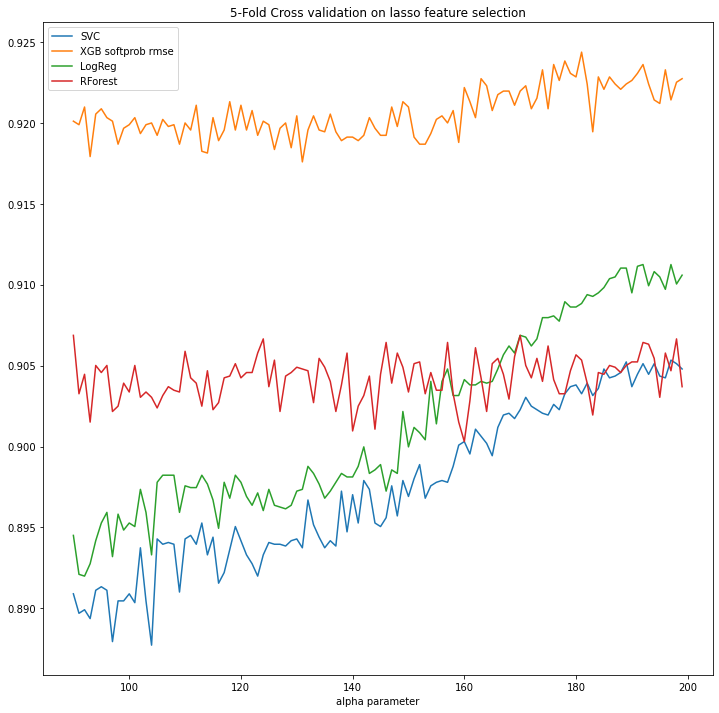

Best SVC:0.9053396116362992 for alpha:197
Best Reg:0.911249983531731 for alpha:192
Best Rfor:0.9068719990322645 for alpha:170
Best XGB:0.9243810026840285 for alpha:181.000000



In [10]:
from xgboost import XGBClassifier

mm_features = []

def make_k_fold(feature_sel_type="Lasso"):
    
    if feature_sel_type == "Lasso":
        #values = list(np.arange(0.00001, 0.00025, 0.00001))
        values = list(np.arange(0.0000002,0.000008,0.0000001))
    else:
        #case of random_forest feature selection
        values = list(range(90,200))
    #rfor best 0.0011 or 0.0010

    svc = []
    reg = []
    rfor = []
    xGb = []
    features = [] 
    for k in values:
        print("index:{} of :{}".format(values.index(k), len(values)))
        if feature_sel_type == "Lasso":
            X,ft = lasso(df, target, alpha=k)
        else:
            #X = kbest_features(df, target,k)
            X, ft = rforest_features(df, target, k)
        
        features.append(ft)
        #------------------------------------------------------------------
        #TODO:
        #cross val manage to balance each fold
        #feature selection make only on 4 of 5 fold only based on training
        #------------------------------------------------------------------
        reg_scores = cross_val_score(LogisticRegression(max_iter=10000,penalty='l1',
                                                        solver='liblinear',C=1.0), X, target,cv=5)
        
        svc_scores = cross_val_score(SVC(kernel='rbf', C=0.9), X, target,cv=5)
        
        for_scores = cross_val_score(RandomForestClassifier(n_estimators=35,
                                                            criterion='gini',
                                                            ccp_alpha=0.0003,
                                                            min_samples_split=4), X, target,cv=5)

        xgb_score = cross_val_score(XGBClassifier(objective="multi:softprob",num_class = 2,
                                                  learning_rate =0.2,n_estimators=100,max_depth=5,
                                                  colsample_bytree = 0.7,
                                                  eval_metric="rmse",use_label_encoder=False), X, target,cv=5)
        
        svc.append(sum(svc_scores)/ len(svc_scores))
        reg.append(sum(reg_scores)/ len(reg_scores) )
        rfor.append(sum(for_scores)/ len(for_scores) )
        xGb.append(sum(xgb_score)/ len(xgb_score))
    
    plt.figure(figsize=(12.0,12.0))
    plt.plot(values, svc, label="SVC")
    plt.plot(values, xGb, label="XGB softprob rmse")
    plt.plot(values, reg, label="LogReg")
    plt.plot(values, rfor, label="RForest")
    #plt.xticks(np.arange(min(values), max(values), 0.00005),rotation=45)
    plt.legend()
    plt.xlabel("alpha parameter")
    plt.title("5-Fold Cross validation on lasso feature selection")
    plt.show()
    print("Best SVC:{} for alpha:{}".format(max(svc), values[svc.index(max(svc))] ) )
    print("Best Reg:{} for alpha:{}".format(max(reg), values[reg.index(max(reg))] ) )
    print("Best Rfor:{} for alpha:{}".format(max(rfor), values[rfor.index(max(rfor))] ) )
    #f_out = open("k_fold_cross_lasso.txt","a+")
    #for i in range(len(xGb)):
    #    if xGb[i] > 0.918:
    #        f_out.write("Best XGB:{} for alpha:{:f} and features:{}\n".format(xGb[i], values[i], features[i] ) )
    #        mm_features.append(set(features[i]))
    print("Best XGB:{} for alpha:{:f}\n".format(max(xGb), values[xGb.index(max(xGb))]))
    #f_out.close()

make_k_fold(feature_sel_type="rfor")


## K-Fold Cross Validation Version 2 (manual implementation of K-fold)
 - Select features at each fold based by train split , each iteration select new features
 - at the end of execution make stratified 70/30 split with union of all selected features

In [49]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
def k_fold_val_2(number_of_features):
    accur_scores = []
    #create Strafied 5 fold class
    kf = StratifiedKFold(n_splits=5)
    all_features = []
    #make 5 fold cross valdation with use of features selected by train split
    for train_index, test_index in kf.split(df,target):
        X_train = df.iloc[train_index]
        X_train, X_test, y_train, y_test = df.iloc[train_index], df.iloc[test_index], target[train_index], target[test_index]

        #select K features with use of random forest feature selection
        X_train_f, ft = rforest_features(X_train, y_train, number_of_features)
        all_features += ft

        #keep only selected features in train and test splits
        X_test_f = X_test[ft]
        xGb_cl = XGBClassifier(objective="multi:softprob",
                               num_class = 2,
                               learning_rate =0.2,
                               n_estimators=100,
                               max_depth=5,
                               colsample_bytree = 0.7,
                               eval_metric="rmse",
                               use_label_encoder=False)
        #fit model with train dataset
        xGb_cl.fit(X_train_f, y_train)

        #predict test dataset and keep prediction labels
        pred = xGb_cl.predict(X_test_f)
        print("Fold accuracy score: ",accuracy_score(y_test, pred))
        accur_scores.append(accuracy_score(y_test, pred))
    accur_scores = sum(accur_scores) / len(accur_scores)
    print("Avg k-fold:{} for :{} features".format(accur_scores, number_of_features))


    #after k-folds keep all selected features and make 70/30 stratified split and train and predict
    all_features = list(set(all_features))
    print("70/30")
    X_train, X_test, y_train, y_test = train_test_split(df[all_features], 
                                                        target,
                                                        test_size=0.3,
                                                        stratify=target)

    xGb_cl = XGBClassifier(objective="multi:softprob",
                           num_class = 2,
                           learning_rate =0.2,
                           n_estimators=100,
                           max_depth=5,
                           colsample_bytree = 0.7,
                           eval_metric="rmse",
                           use_label_encoder=False)

    xGb_cl.fit(X_train, y_train)
    pred = xGb_cl.predict(X_test)
    print("Final accuracy score:",accuracy_score(y_test, pred))
    return accur_scores, accuracy_score(y_test, pred)

k_fold_val_2(number_of_features=300)

Fold accuracy score:  0.9266958424507659
Fold accuracy score:  0.9184901531728665
Fold accuracy score:  0.9206783369803063
Fold accuracy score:  0.9255610290093049
Fold accuracy score:  0.9184455391351943
Avg k-fold:0.9219741801496875 for :300 features
70/30
Final accuracy score: 0.9212253829321663


(0.9219741801496875, 0.9212253829321663)

### Dimentionality reduction t-SNE

In [ ]:
#X, _ = lasso_features(df, target, 4)
#X,_ = lasso(df, target, alpha=0.00002)
X = rforest_features(df, target, 56)
tsne_2d = make_tsne(X, target, "full dataset",learning_rate=100, perplexity=20)
#tsne_2d = make_tsne(X, target, "full dataset")
#tsne_2d = make_tsne(X, target, "full dataset")
#print("Plot t-SNE for train dataset with features selected from train portion")
#make_tsne(X_train_scaled, y_train, "train dataset")
#print("Plot t-SNE for test dataset with features selected from train portion")
#make_tsne(X_test_scaled, y_test, "test dataset")

### Dimentionality reduction UMAP

In [ ]:
#X, _ = lasso_features(df, target, 4)
umap_2d = perofrm_umap_clustering(X, target, "all dataset")
#embedding = perofrm_umap_clustering(X, target, "all dataset")
#embedding = perofrm_umap_clustering(X, target, "all dataset")
#perofrm_umap_clustering(X_test_scaled, y_test,  "test dataset")
#perofrm_umap_clustering(X_train_scaled, y_train, "train dataset")

### Clustering DBSCAN

In [ ]:
#dbscan_clustering(tsne_2d, 0.00557, 25)
#dbscan_clustering(tsne_2d, 0.0045, 25)
#dbscan_clustering(tsne_2d, 0.0057, 30)
#dbscan_clustering(umap_2d,0.007, 30)
#dbscan_clustering(umap_2d,0.0025, 20)
dbscan_clustering(umap_2d,0.0025, 20)
#dbscan_clustering(X, 0.00557, 25)


## Mean-Shift 

In [ ]:
mean_shift(tsne_2d)

## Cosine Similarity

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
res = cosine_similarity(X,Y= None, dense_output=True)
pairs = set()
f_out = open("cosine_graph.dot","w+")
f_out.write("digraph {\n")
for i in range(0, res.shape[0]):
    f_out.write("\t\"{}\"     [label=\"{}\"];\n".format(i,i))
    #    "1" -- "2" [weight=100];")
for i in range(0,res.shape[0]):
    max_sim = res[i,list(set(range(0,39123)) - set([i]))]
    max_sim = [x for x in max_sim if x >= 0.9]
    if len(max_sim) == 0:
        continue
    max_sim.sort(reverse=True)
    if len(max_sim) > 5:
        max_sim = max_sim[:5]
    
    
    #print(max_sim)
    #print(np.where(res[1,:] == max_sim))
    for m_value in max_sim:
        line = "\t\"{}\" -- \"{}\" [weight={}];\n".format(i, np.where(res[i,:] == m_value)[0][0], int(m_value*100.0))
        line_rev = "\t\"{}\" -- \"{}\" [weight={}];\n".format(np.where(res[i,:] == m_value)[0][0], i, int(m_value*100.0))
        if line in pairs or line_rev in pairs:
            continue
        pairs.add(line)
        #print(line)
        f_out.write(line)
f_out.write("}")
f_out.close()

## GaussianMixture

In [ ]:
gmm = GaussianMixture(n_components=2,n_init=100,init_params = "kmeans",covariance_type = "full")
#X, _ = lasso_features(df, target, 10)
#X = kbest_features(df, target, 3)
gmm.fit(X)

#predictions from gmm
labels = gmm.predict(X)
TP = [True if labels[i]==1 and target[i] == 1 else False for i in range(len(target)) ].count(True)
TN = [True if labels[i]==0 and target[i] == 0 else False for i in range(len(target)) ].count(True)
FP = [True if labels[i]==1 and target[i] == 0 else False for i in range(len(target)) ].count(True)
FN = [True if labels[i]==0 and target[i] == 1 else False for i in range(len(target)) ].count(True)
P = len(target[target == 1])
N = len(target[target == 0])
print("True pos :{} tp rate:{}".format(TP,TP/P))
print("True neg :{} tn rate:{}".format(TN, TN/N))
print("False pos :{} fp rate:{}".format(FP,FP/N))
print("False neg :{} fn rate:{}".format(FN,FN/P))

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt 

#X = lasso_features(df, target, 4)
#X = rforest_features(df, target, 4)
TPR_L = []
TNR_L = []
FNR_L = []
FPR_L = []
purity = []
#for n_features in range(1,10):
for j in range(2,40):
    #X = kbest_features(df, target, n_features)
    X, _ = lasso_features(df, target, 4)
    #X = rforest_features(df, target, 4)
   
    TPR = []
    TNR = []
    FPR = []
    FNR = []
    tmp_pur = []
    for k in range(0,10):
        gmm = GaussianMixture(n_components=j,init_params = "kmeans",covariance_type = "full")
        gmm.fit(X)

        #predictions from gmm
        labels = gmm.predict(X)
        tmp_pur.append(compute_pur(labels,target))
        TP = [True if labels[i]==1 and target[i] == 2 else False for i in range(len(target)) ].count(True)
        TN = [True if labels[i]==0 and target[i] == 0 else False for i in range(len(target)) ].count(True)
        FP = [True if labels[i]==1 and target[i] == 0 else False for i in range(len(target)) ].count(True)
        FN = [True if labels[i]==0 and target[i] == 2 else False for i in range(len(target)) ].count(True)
        P = len(target[target == 2])
        N = len(target[target == 0])
        TPR.append(TP/P)
        TNR.append(TN/N)
        FPR.append(FP/N)
        FNR.append(FN/P)
    purity.append(sum(tmp_pur) / len(tmp_pur))
    TPR = sum(TPR) / len(TPR)
    TNR = sum(TNR) / len(TNR)
    FPR = sum(FPR) / len(FPR)
    FNR = sum(FNR) / len(FNR)
    
    #print("Number of features:{} TPR:{} TNR:{} FNR:{} FPR:{}".format(n_features, TPR, TNR, FNR, FPR))
    TPR_L.append(TPR)
    TNR_L.append(TNR)
    FNR_L.append(FNR)
    FPR_L.append(FPR)
plt.figure(figsize=(12.0,12.0))
plt.plot(range(1,len(TPR_L)+1) ,TPR_L, label="True Positive", color="Blue" )
plt.plot(range(1,len(TNR_L)+1) ,TNR_L, label="True Negative", color="Green" )
plt.plot(range(1,len(FNR_L)+1) ,FNR_L, label="False Negative", color="Red")
plt.plot(range(1,len(FPR_L)+1) ,FPR_L, label="False Positive" , color ="y")
plt.xticks(range(1,len(FPR_L)+1))
plt.xlabel("Number of cluster")
plt.legend()
plt.show()
plt.clf()
plt.figure(figsize=(12.0,12.0))
plt.plot(range(2,40),purity, label="Purity avg")
plt.title("Avg cluster purity")
plt.show()
print(1+TPR_L.index(max(TPR_L)))
print(1+TNR_L.index(max(TNR_L)))
print(1+FNR_L.index(min(FNR_L)))
print(1+FPR_L.index(min(FPR_L)))


    
    


### Anomaly detection


In [ ]:
from sklearn.covariance import EllipticEnvelope
X, _ = lasso_features(df, target, 4)
X_s = X[target==0,:]
print(X_s.shape)
cov = EllipticEnvelope().fit(X)
res = cov.predict(X)
print(len(target))
labels = [target[i] for i in range(len(res)) if res[i] == -1]

print("Wrong:",labels.count(0))
print("Right:",labels.count(2))
gm = GaussianMixture(n_components=2)
gm.fit(X)
densities = gm.score_samples(X)
print(len(densities))
density_threshold = np.percentile(densities, 4)
anomalies = np.where(densities < density_threshold)[0]
labels = [target[i] for i in anomalies]
print(labels.count(0))
print(labels.count(2))
#print(anomalies)

In [ ]:
from sklearn.mixture import BayesianGaussianMixture
X, _ = lasso_features(df, target, 4)
print(set(target))
bgm = BayesianGaussianMixture(n_components=3, n_init=10, random_state=0,covariance_type='tied',init_params='kmeans')
bgm.fit(X)
labels = bgm.predict(X)

labels[target == 2]

TP = [True if labels[i]==2 and target[i] == 2 else False for i in range(len(target)) ].count(True)
TN = [True if labels[i]==0 and target[i] == 0 else False for i in range(len(target)) ].count(True)
FP = [True if labels[i]==2 and target[i] == 0 else False for i in range(len(target)) ].count(True)
FN = [True if labels[i]==0 and target[i] == 2 else False for i in range(len(target)) ].count(True)
P = len(target[target == 2])
N = len(target[target == 0])
print("True pos :{} tp rate:{}".format(TP,TP/P))
print("True neg :{} tn rate:{}".format(TN, TN/N))
print("False pos :{} fp rate:{}".format(FP,FP/N))
print("False neg :{} fn rate:{}".format(FN,FN/P))


In [ ]:
# calculate interquartile range
def remove_outliers(data, labels):
    all_outliers = set()
    for i in range(data.shape[1]):
        q25, q75 = np.percentile(data[:,i], 25), np.percentile(data[:,i], 75)
        iqr = q75 - q25
        # calculate the outlier cutoff
        cut_off = iqr * 1.5
        lower, upper = q25 - cut_off, q75 + cut_off
        # identify outliers
        outliers = set()
        for x in data[:,i]:
            if x < lower or x > upper:
                outliers = set(np.where(data[:,i] == x)[0]).union(outliers)
        #outliers = [np.where(X[:,i] == x)[0] for x in X[:,i] if x < lower or x > upper]
        #print(len(outliers))
        #print(len(set(outliers)))
        all_outliers = all_outliers.union(outliers)
    #print("----")
    #print(len(all_outliers))
    l = [labels[i] for i in all_outliers]
    #print(l.count(0))
    #print(l.count(1))
    #print(l.count(2))
    ind_clear = list(set(range(X.shape[0])) -all_outliers)
    X_clear = data[ind_clear,:]
    target_clear = labels[ind_clear]
    #print(X_clear.shape)
    return X_clear, target_clear
#print(len(outliers))
#print(target[outliers])

In [ ]:
from sklearn.mixture import BayesianGaussianMixture
#X, _ = lasso_features(df, target, 4)
print(set(target))
#bgm = BayesianGaussianMixture(n_components=3, n_init=10, random_state=0,covariance_type='tied',init_params='kmeans')
bgm = GaussianMixture(n_components=3, n_init=10,max_iter=1000, random_state=0,covariance_type = "full",init_params='kmeans')

bgm.fit(X_clear)
labels = bgm.predict(X_clear)

print(labels[target_clear == 2])

TP = [True if labels[i]==2 and target_clear[i] == 2 else False for i in range(len(target_clear)) ].count(True)
TN = [True if labels[i]==0 and target_clear[i] == 0 else False for i in range(len(target_clear)) ].count(True)
FP = [True if labels[i]==2 and target_clear[i] == 0 else False for i in range(len(target_clear)) ].count(True)
FN = [True if labels[i]==0 and target_clear[i] == 2 else False for i in range(len(target_clear)) ].count(True)
P = len(target_clear[target_clear == 2])
N = len(target_clear[target_clear == 0])
print("True pos :{} tp rate:{}".format(TP,TP/P))
print("True neg :{} tn rate:{}".format(TN, TN/N))
print("False pos :{} fp rate:{}".format(FP,FP/N))
print("False neg :{} fn rate:{}".format(FN,FN/P))

In [ ]:
r = labels[target_clear == 2]
print(len(np.where(r == 0)[0]))
print(len(np.where(r == 1)[0]))
print(len(np.where(r == 2)[0]))
print("------------")
r = labels[target_clear == 1]
print(len(np.where(r == 0)[0]))
print(len(np.where(r == 1)[0]))
print(len(np.where(r == 2)[0]))
print("------------")
r = labels[target_clear == 0]
print(len(np.where(r == 0)[0]))
print(len(np.where(r == 1)[0]))
print(len(np.where(r == 2)[0]))

In [ ]:
import matplotlib.pyplot as plt
df, target, user_ids = read_data("features_large_extra.csv")
#new_lb = { int(i.split(" ")[0]) : int(i.split(" ")[1]) for i in open('labels_sample.txt','r').read().split("\n") if i != ''}
#new_target = np.array([new_lb[user_ids[u]] for u in range(len(user_ids))])
#print(new_target.shape)
print(target.shape)
#X, _ = lasso_features(df, target, 5)
#X = rforest_features(df, target, 5)
#X = kbest_features(df, new_target, 5)
#X_clear, target_clear = remove_outliers(X, target)
#clusters = dbscan_clustering(X_clear, 0.03, 25)
#print(set(clusters))
#cc = defaultdict(lambda: set())
#for i in range(len(clusters)):
#    cc[clusters[i]].add(i)
#g_1 = set(np.where(target_clear == 1)[0])
#g_2 = set(np.where(target_clear == 2)[0])
#g_0 = set(np.where(target_clear == 0)[0])
#for c in cc:
#    if c == -1:
#        continue
#    print(" Inter g_0: {} g_1: {} g_2: {}".format(len(g_0.intersection(cc[c])),  len(g_1.intersection(cc[c])), len(g_2.intersection(cc[c])) ))
    
from sklearn.metrics import accuracy_score

for f in range(1,10):
    bic = []
    aic=[]
    plt.figure(figsize=(12.0,12.0))
    X, _ = lasso_features(df, target, f)
    print("Features:{}".format(f))
    for n in range(1,50):
        bgm = GaussianMixture(n_components=n, n_init=10,max_iter=10000, random_state=0,covariance_type = "tied",init_params='kmeans')

        bgm.fit(X)
        bic.append(bgm.bic(X))
        aic.append(bgm.aic(X))
    plt.plot(range(len(bic)), bic,label="Bic")
    plt.plot(range(len(aic)), aic,label="Aic")
    plt.legend()
    plt.savefig("GM_f_{}_tied.png".format(f))
    plt.clf()
#accuracy_score(target, labels)

In [ ]:
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
df, target, user_ids = read_data("features_large_extra.csv")

print(target.shape)
#X, _ = lasso_features(df, target, 5)
#X = rforest_features(df, target, 5)
#X = kbest_features(df, new_target, 5)
#X_clear, target_clear = remove_outliers(X, target)

score = []
inhert = []
aic=[]
purity = []
avg_cl_size = []
plt.figure(figsize=(12.0,12.0))
X, _ = lasso_features(df, target, 50)
clusters = range(2,30)
for k in clusters:
    # Declaring Model
    model = KMeans(n_clusters=k)

    # Fitting Model
    model.fit(X)
    score.append(silhouette_score(X, model.labels_))
    inhert.append(model.inertia_)
    purity.append(compute_pur(model.labels_,target))
    avg_cl_size.append(compute_size(model.labels_))
plt.plot(  clusters, score)
plt.plot(  clusters, inhert)
plt.xticks(clusters,rotation=45)
plt.xlabel("K number")
plt.ylabel("Score")
plt.title("K-means scores for mutliple number of clusters")
plt.show()
plt.clf()
plt.figure(figsize=(12.0,12.0))

plt.plot( clusters, purity)
plt.title("Cluster purity")
plt.show()
plt.figure(figsize=(12.0,12.0))


plt.plot( clusters, avg_cl_size)
plt.title("Avg cluster size")
plt.show()


In [ ]:
#print(len(model.labels_))
#print(model.labels_[0])
#print(type(model.labels_[0]))
#print(type(target[1]))
#print(target[1])
def compute_pur(labels,target):
    d = defaultdict(lambda: [])
    for i in range(len(labels)):
        d[int(labels[i])].append(int(target[i]))
    cluster_purity = []
    for c in d:
        max_tar = max(d[c])
        cluster_purity.append(max_tar/len(d[c]))
    return sum(cluster_purity)/ len(cluster_purity)

def compute_size(labels):
    d = defaultdict(lambda: [])
    for i in range(len(labels)):
        d[int(labels[i])].append(int(target[i]))
    clusters = [len(d[x]) for x in d]
    
    return sum(clusters)/ len(clusters)

In [ ]:
# Importing Modules
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
import pandas as pd

# Reading the DataFrame
#seeds_df = pd.read_csv(
#    "https://raw.githubusercontent.com/vihar/unsupervised-learning-with-python/master/seeds-less-rows.csv")

# Remove the grain species from the DataFrame, save for later
#varieties = list(seeds_df.pop('grain_variety'))

# Extract the measurements as a NumPy array
#samples = seeds_df.values

"""
Perform hierarchical clustering on samples using the
linkage() function with the method='complete' keyword argument.
Assign the result to mergings.
"""
mergings = linkage(X, method='complete')

"""
Plot a dendrogram using the dendrogram() function on mergings,
specifying the keyword arguments labels=varieties, leaf_rotation=90,
and leaf_font_size=6.
"""
dendrogram(mergings,
           labels=varieties,
           leaf_rotation=90,
           leaf_font_size=6,
           )

plt.show()

In [ ]:
X, _ = lasso_features(df, target, 4)
for i in range(10,250,10):
    print("i:{}".format(i))
    tsne_2d = make_tsne(X, target, "full dataset", learning_rate=350, perplexity=i)

In [ ]:
df, target, user_ids = read_data("features_large_extra.csv")
X, _ = lasso_features(df, target, 4)


In [ ]:
perofrm_umap_clustering(X, target,  "Full", n_neighbors=25, n_components=30)

In [ ]:
from sklearn.linear_model import SGDClassifier

scores = []
for j in range(100):
    df, target, user_ids = read_data("features_large_extra.csv")
    X = rforest_features(df, target, 40)
    for i in range(1000):
        clf = XGBClassifier(objective="multi:softprob",
                            num_class = 2,
                            learning_rate =0.2,
                            n_estimators=100,
                            max_depth=5,
                            colsample_bytree = 0.7,
                            eval_metric="rmse",
                            use_label_encoder=False)
        X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.3,)
        clf.fit(X_train, y_train)
        scores.append(clf.score(X_test,y_test))
    
print("Avg score:{}".format(sum(scores)/len(scores)))

